<h1><b>MID<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 회귀(Mall_Customer.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import</b></h2>

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

<h2><b>1. 데이터 로딩</b></h2>

In [20]:
# URL
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/Mall_Customers.csv"

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url)

# 데이터 확인
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [21]:
# 컬렴명 확인
print(df.columns)

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [22]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수의 분포를 확인</li>

,count
Spending Score (1-100),
42,8
55,7
73,6
46,6
48,5
...,...
68,1
85,1
23,1


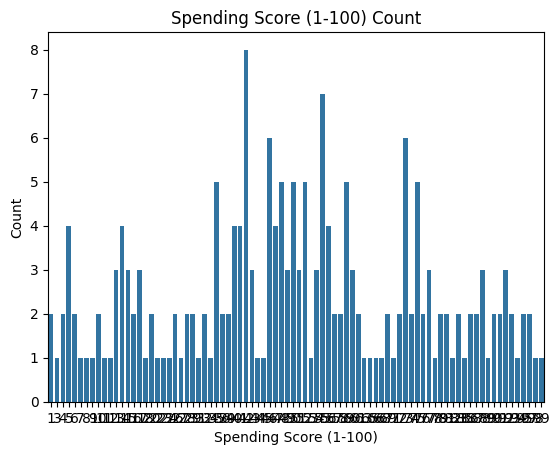

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# 레이블 갯수 확인 (그래프)
sns.countplot(data=df, x="Spending Score (1-100)")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Count")
plt.title("Spending Score (1-100) Count")
# 레이블 갯수 확인 (숫자)
df['Spending Score (1-100)'].value_counts()

<h2><b>4. 데이터 전처리</b></h2>

In [24]:
from torch.utils.data import Dataset, DataLoader
X = df.drop(columns=["Spending Score (1-100)", "Gender"])
y = df["Spending Score (1-100)"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Dataset
class Score_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(Score_Dataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(Score_Dataset(X_val, y_val), batch_size=32, shuffle=False)

<h2><b>5. 모델 정의</b></h2>

In [25]:
# 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionModel()

<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [27]:
# 학습
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    train_losses.append(running_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))

    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100, Train Loss: 3352.0498, Val Loss: 2395.4830
Epoch 10/100, Train Loss: 3167.6670, Val Loss: 2243.9297
Epoch 20/100, Train Loss: 2594.7475, Val Loss: 1786.7450
Epoch 30/100, Train Loss: 1548.4006, Val Loss: 1022.0053
Epoch 40/100, Train Loss: 887.5547, Val Loss: 619.9406
Epoch 50/100, Train Loss: 792.0128, Val Loss: 567.4640
Epoch 60/100, Train Loss: 749.1842, Val Loss: 529.0423
Epoch 70/100, Train Loss: 716.0940, Val Loss: 505.7818
Epoch 80/100, Train Loss: 687.9727, Val Loss: 488.5901
Epoch 90/100, Train Loss: 664.5475, Val Loss: 477.8409
Epoch 100/100, Train Loss: 644.8105, Val Loss: 466.9037


<h2><b>8. 학습곡선 시각화 </b></h2>

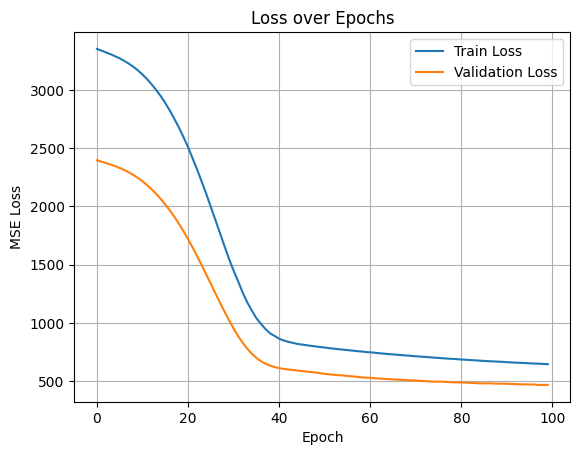

In [28]:
# Loss 시각화
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

<h2><b>9. 모델 평가 </b></h2>

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model.eval()
preds, targets = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        preds.extend(outputs.numpy().flatten())
        targets.extend(y_batch.numpy().flatten())

mae = mean_absolute_error(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 17.3166
RMSE: 21.6080
